In [1]:
from __future__ import print_function

import math
import numpy as np
import os
import sys
import fnmatch
import scipy.optimize as op
from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as pl
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from linetools.spectra.xspectrum1d import XSpectrum1D
import model_NaI
import model_fitter
import continuum_normalize_NaI
#import NaImcmc_read_fits
#import NaImcmc_fitwrapper
#import ew_NaI_allspax
import pdb
import corner 

import numpy as np
import pandas as pd
import scipy.stats as st
import numba

import emcee
import ptemcee

import bebi103

import bokeh.io
import bokeh.plotting

from bokeh.plotting import figure, show
from bokeh.layouts import row
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CustomJS, Slider,Div,SingleIntervalTicker,ColorBar
from bokeh.models.mappers import LinearColorMapper, LogColorMapper
from bokeh.models import Step, Label
from astropy.table import Table
import time
import pandas as pd
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.io import curdoc
from bokeh import events
from bokeh.models import Span,Square,HoverTool,Range1d
import colorcet as cc

bokeh.io.output_notebook()

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/bebi103/viz.py:38: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


ImportError: cannot import name 'Square' from 'bokeh.models' (/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/bokeh/models/__init__.py)

In [ ]:
outdir = '/Users/erickaguirre/Desktop/NaI_MCMC_output/'

# directory path for NGC 4030
path = '/Users/erickaguirre/Desktop/DAP_outputs/'
bin_dir = 'output0.6_'
gal_name = 'NGC4030'
gal_sub_dir = '/SQUARE0.6-MILESHC-MASTARSSP/1/1/'

# For continuum-normalization around NaI
# wavelength continuum fitting range outside of NaI region
blim = [5850.0,5870.0]
rlim = [5910.0,5930.0]
# wavelength fitting range inside of NaI region
fitlim = [5880.0,5910.0]
# speed of light in km/s
c = 2.998e5

# log cube model and data file path
log_cube_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARSSP.fits' 
# log maps file path
log_maps_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARSSP.fits.gz'

In [6]:
# Need LSF in km/s
# This gives LSF in Ang
# CAUTION: this does not convert air wavelengths
# to vacuum, or account for velocity offset of each bin
redshift = 0.00489 
LSFdir = '/Users/erickaguirre/Desktop/SDSU_Research/Getting_used_to_MaNGA_DAP/'
LSFfil = LSFdir + 'LSF-Config_MUSE_WFM'
configLSF = np.genfromtxt(LSFfil, comments='#')
configLSF_wv_air = configLSF[:,0]
configLSF_res = configLSF[:,1]

# convert to vacuum since LSF is in air
xspec = XSpectrum1D.from_tuple((configLSF_wv_air, 0.0*configLSF_wv_air))
xspec.meta['airvac'] = 'air'
xspec.airtovac()
configLSF_wv_vac = xspec.wavelength.value

configLSF_restwv = configLSF_wv_vac / (1.0+redshift)
whLSF = np.where((configLSF_restwv > fitlim[0]) & (configLSF_restwv < fitlim[1]))

median_LSFAng = np.median(configLSF_res[whLSF[0]])
median_LSFvel = c * median_LSFAng / np.median(configLSF_wv_vac[whLSF[0]])
LSFvel = median_LSFvel

/Users/erickaguirre/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


In [7]:
# log maps file 
hdu_map = fits.open(log_maps_fil)
# bin ID has multiple layers of the same bin id map so use first one
binid_map = hdu_map['BINID'].data[0]

# stellar velocity map
ppxf_v_map = hdu_map['STELLAR_VEL'].data

# Read in binned spectra
# extract cube data  spectrum
hdu_cube = fits.open(log_cube_fil)
spec = hdu_cube['FLUX'].data

# extract error spectrum from cube
ivar = hdu_cube['IVAR'].data
espec = np.sqrt(1/ivar)

# observed wavelength
obswave = hdu_cube['WAVE'].data

# NGC 4030 redshift's
redshift = 0.00489 
wave = obswave / (1.0+redshift)

# extract cube best-fit model spectrum
mod = hdu_cube['MODEL'].data


sv_binnumber = []
sv_samples = []
sv_percentiles = []
sv_velocities = []

nbins = np.unique(binid_map)[-1]
binsperrun = 600
nruns = int(nbins / binsperrun)

startbinid = 4172
endbinid = 4173

# Set up array with all relevant binids
fitbins = np.arange(startbinid,endbinid+1)

/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Running MCMC...
Done.


<Figure size 432x288 with 0 Axes>

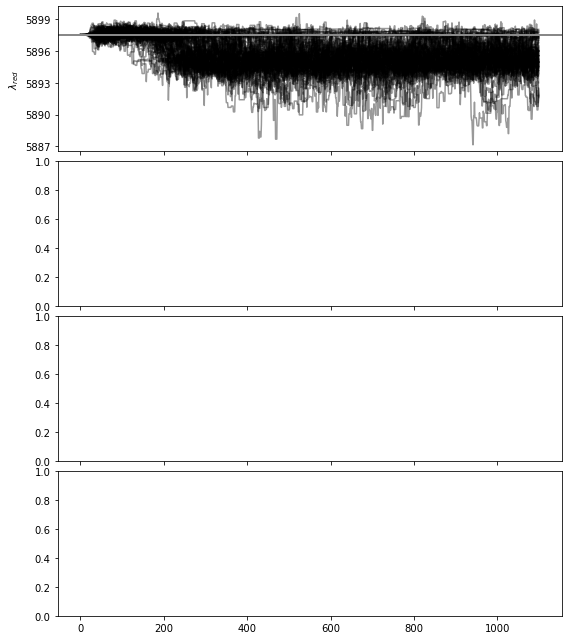

MCMC result:
 par 0 = 5895.398481841221 +1.7352055023975481 -0.9226831015666903
 par 1 = 15.023025617550491 +1.0242131950553421 -0.7011508897596919
 par 2 = 92.78375375726772 +47.226838495343415 -35.40461841934006
 par 3 = 0.11799747524707643 +0.03054020041140046 -0.01799558353156408
Time elapsed for bin 4172: 4.90 minutes


/Users/erickaguirre/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [8]:
import time 
start = time.time()
for qq in fitbins:
    ind = binid_map == qq
    # single bin velocity
    binvel = ppxf_v_map[ind][0]
    # single flux, error and model spectrum corresponding to that bin 
    flux_bin = np.ma.array(spec[:,ind][:,0])
    err_bin = np.ma.array(espec[:,ind][:,0])
    mod_bin = np.ma.array(mod[:,ind][:,0])

    # Determine bin redshift: cz in km/s = tstellar_kin[*,0]
    # bin_z = (cz + stellar_vfield[qq]) / sol
    # cosmo_z = cz / sol
    bin_z = redshift + ((1 + redshift) * binvel / c)
    restwave = obswave / (1.0 + bin_z)
    
    ndata = continuum_normalize_NaI.norm(restwave, flux_bin, err_bin, blim, rlim, FIT_FLG=0)

    # Cut out NaI
    select = np.where((ndata['nwave'] > fitlim[0]) & (ndata['nwave'] < fitlim[1]))
    restwave_NaI = ndata['nwave'][select].astype('float64')
    flux_NaI = ndata['nflux'][select].astype('float64')
    err_NaI = ndata['nerr'][select].astype('float64')
    sres_NaI = LSFvel

    data = {'wave':restwave_NaI, 'flux':flux_NaI, 'err':err_NaI, 'velres':sres_NaI}
    
    # check for bad data being masked
    if data['flux'].mask.all() == True:
        sv_binnumber.append(binid_map[ind][0])
        sv_samples.append(np.zeros((100,1100,4)))
        sv_percentiles.append(np.zeros((4,3)))
        sv_velocities.append(-999)
        continue

    # Guess good model parameters
    lamred = 5897.5581
    logN = 15.0
    bD = 20.0
    Cf = 0.6
    theta_guess = lamred, logN, bD, Cf
    guess_mod = model_NaI.model_NaI(theta_guess, data['velres'], data['wave'])
    datfit = model_fitter.model_fitter(data, theta_guess,linetimefil='linefit.pdf')

    # Run the MCMC
    datfit.mcmc()
    #transinfo = model_NaI.transitions()

    # get gas velocity from model lambda and rest lambda
    lamred_mcmc, logN_mcmc, bD_mcmc, Cf_mcmc = datfit.theta_percentiles
    lamrest = 5897.5581
    velocity = ((lamred_mcmc[0] / lamrest) - 1) * c

    sv_binnumber.append(binid_map[ind][0])
    sv_samples.append(datfit.samples)
    sv_percentiles.append(datfit.theta_percentiles)
    sv_velocities.append(velocity)
    end = time.time()
    print('Time elapsed for bin {}: {:.2f} minutes'.format( qq,(end-start)/60 ))
    
t = Table([sv_binnumber, sv_samples,sv_percentiles, sv_velocities], \
              names=('bin', 'samples','percentiles','velocities'))

# # model_fit = model_NaI.model_NaI(t['percentiles'][0][:,0], data['velres'], data['wave'])
# # pl.step(data['wave'],data['flux'],label = 'data')
# # pl.plot(model_fit['modwv'],model_fit['modflx'],label='model')
# # pl.legend()
# # pl.plot()

In [11]:
print(t['percentiles'][0][])

array([[5.89539848e+03, 1.73520550e+00, 9.22683102e-01],
       [1.50230256e+01, 1.02421320e+00, 7.01150890e-01],
       [9.27837538e+01, 4.72268385e+01, 3.54046184e+01],
       [1.17997475e-01, 3.05402004e-02, 1.79955835e-02]])

In [23]:
ndim = 4
burnin = 1000
sample_burnin = t['samples'][0][:, burnin:, :].reshape((-1, ndim))
sample_burnin.shape

(10000, 4)

In [25]:
samples = t['samples'][0]
p8_1 = figure(title="Samples", y_axis_label='lambda_red',plot_height = 125,plot_width = 500 )
p8_2 = figure(y_axis_label='N' )
p8_3 = figure(y_axis_label='b_d')
p8_4 = figure(y_axis_label='C_f')

# Guess good model parameters
lamred = 5897.5581
logN = 15.0
bD = 20.0
Cf = 0.6

lam_line = Span(location=lamred,dimension='width', line_color='grey', line_width=2)
N_line = Span(location=logN,dimension='width', line_color='grey', line_width=2)
bd_line = Span(location=bD,dimension='width', line_color='grey', line_width=2)
Cf_line = Span(location=Cf,dimension='width', line_color='grey', line_width=2)

iterations = np.arange(samples.shape[1])

for i in range(samples.shape[0]):
    p8_1.line(iterations,samples[i,:,0],line_alpha=0.4,line_color='black')
    p8_1.add_layout(lam_line)
    p8_2.line(iterations,samples[i,:,1],line_alpha=0.4,line_color='black')
    p8_2.add_layout(N_line)
    p8_3.line(iterations,samples[i,:,2],line_alpha=0.4,line_color='black')
    p8_3.add_layout(bd_line)
    p8_4.line(iterations,samples[i,:,3],line_alpha=0.4,line_color='black')
    p8_4.add_layout(Cf_line)

grid8 = gridplot([[p8_1],[p8_2],[p8_3],[p8_4]],plot_width=535, plot_height=120)
show(grid8)

In [60]:
# params = [r'lambda_red', 'N', 'b_d','C_f']
# d = {'lambda_red': t['samples'][0][:,0], 'N': t['samples'][0][:,1], \
#     'b_d': t['samples'][0][:,2], 'C_f': t['samples'][0][:,3]}
# df1 = pd.DataFrame(data=d)

#samples = t1['samples'][0]
for i in range(2):
    if np.isnan(t['samples'][i]).all() ==  True:
        lambda_red = np.zeros(int(1e3))
        N = np.zeros(int(1e3))
        b_d = np.zeros(int(1e3))
        C_f = np.zeros(int(1e3))

    else: 
        lambda_red = t['samples'][i][:,0]
        N = t['samples'][i][:,1]
        b_d = t['samples'][i][:,2]
        C_f = t['samples'][i][:,3]
        
    d = {'lambda_red': lambda_red, 'N': N, \
        'b_d': b_d, 'C_f': C_f}
    df1 = pd.DataFrame(data=d)
    g = bebi103.viz.corner(df1,parameters=params)
    bokeh.io.show(g)

In [67]:
np.array(t['percentiles'][0]).shape

(4, 3)

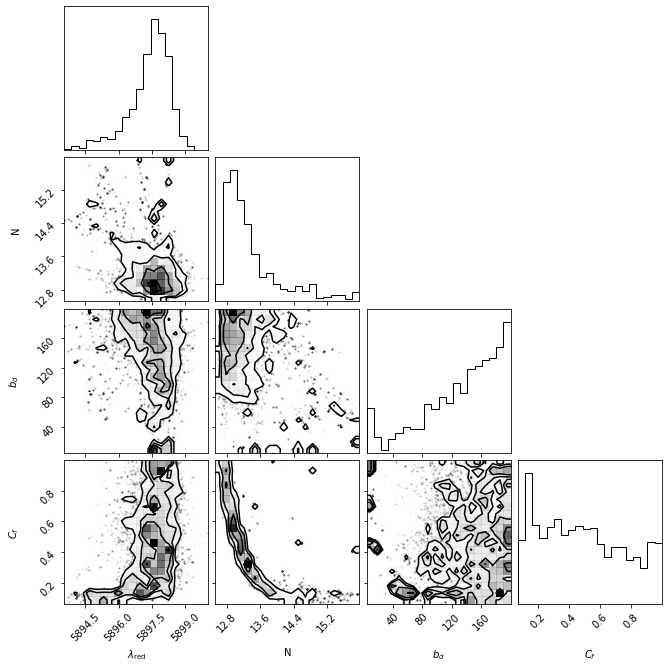

In [48]:
labels = [r'$\lambda_{\mathrm{red}}$','N',r'$b_d$',r'$C_f$']
figure = corner.corner(t1['samples'][0],labels=labels)

In [6]:
for qq in fitbins:

    ind = binid_map == qq
    # single bin velocity
    binvel = ppxf_v_map[ind][0]
    # single flux, error and model spectrum corresponding to that bin 
    flux_bin = np.ma.array(spec[:,ind][:,0])
    err_bin = np.ma.array(espec[:,ind][:,0])
    mod_bin = np.ma.array(mod[:,ind][:,0])

    # Determine bin redshift: cz in km/s = tstellar_kin[*,0]
    # bin_z = (cz + stellar_vfield[qq]) / sol
    # cosmo_z = cz / sol
    bin_z = redshift + ((1 + redshift) * binvel / c)
    restwave = obswave / (1.0 + bin_z)

    ndata = continuum_normalize_NaI.norm(restwave, flux_bin, err_bin, blim, rlim, FIT_FLG=0)

    # Cut out NaI
    select = np.where((ndata['nwave'] > fitlim[0]) & (ndata['nwave'] < fitlim[1]))
    restwave_NaI = ndata['nwave'][select].astype('float64')
    flux_NaI = ndata['nflux'][select].astype('float64')
    err_NaI = ndata['nerr'][select].astype('float64')
    sres_NaI = LSFvel

    data = {'wave':restwave_NaI, 'flux':flux_NaI, 'err':err_NaI, 'velres':sres_NaI}
print(data)

{'wave': array([5880.89892578, 5881.89306641, 5882.88671875, 5883.88085938,
       5884.87548828, 5885.87011719, 5886.86474609, 5887.85986328,
       5888.85449219, 5889.84960938, 5890.84521484, 5891.84082031,
       5892.83642578, 5893.83251953, 5894.82861328, 5895.82470703,
       5896.82128906, 5897.81787109, 5898.81445312, 5899.81152344,
       5900.80859375, 5901.80566406, 5902.80322266, 5903.80078125,
       5904.79833984, 5905.79638672, 5906.79443359, 5907.79248047,
       5908.79150391, 5909.78955078]), 'flux': masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True],
       fil

<Table length=2>
 bin  ...     velocities    
int32 ...      float64      
----- ... ------------------
 4172 ... 0.5179838846126383
 4173 ...             -999.0

(5500.0, 6200.0)

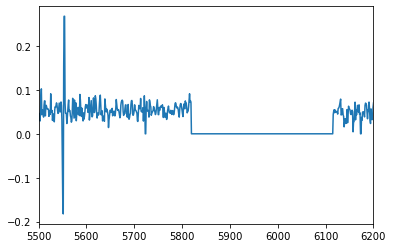

In [25]:
pl.plot(restwave,flux_bin)
pl.xlim(5500,6200)

In [6]:
pl.plot(np.arange(0,10000),t['samples'][1][:,0],alpha=0.2)
pl.axhline(,c='orange')

SyntaxError: invalid syntax (<ipython-input-6-1d30b1462157>, line 2)